# MLP classification

In [34]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

from src.utils.viz import *

plt.style.use('ggplot')

In [2]:
# Read & split train test
filename = './data/clean_entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

## Data preprocessing

In [3]:
# Encoding
def get_vocabulary(iter_sents):
    vocab = set()
    max_length = 0
    for text in iter_sents:
        tokens = text.split(' ')
        if len(tokens) > max_length:
            max_length = len(tokens)
        vocab.update(tokens)
    return vocab, max_length

vocab, max_length = get_vocabulary(df_train['clean_text'])

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])

In [4]:
# Padding
padded_seqs_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_length,
                                                            padding='post', truncating='post')
padded_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_length,
                                                            padding='post', truncating='post')

In [5]:
# Data sets
X_train = padded_seqs_train
X_test = padded_seqs_test
y_train = df_train['target'].values
y_test = df_test['target'].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

In [6]:
# Build an index for embeddings
embeddings_index = {}
EMBEDDINGS_PATH = '/datascience/embeddings'
EMBEDDINGS_LENGTH = 50
print('Reading lines')
with open(os.path.join(EMBEDDINGS_PATH, 'glove.6B.50d.txt'), encoding='utf-8') as f:
    lines = f.readlines()

print('Extract embeddings')
for line in lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Create embeddings matrix')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDINGS_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Reading lines
Extract embeddings
Create embeddings matrix


## Training model

In [15]:
# Model
model = tf.keras.Sequential()
model.add(a := tf.keras.layers.Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDINGS_LENGTH, input_length=max_length,
                                         weights=[embedding_matrix], trainable=False))
model.add(b := tf.keras.layers.Flatten())
model.add(c := tf.keras.layers.Dense(256, activation='relu'))
model.add(d := tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

EPOCHS = 40
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/40
69/69 [==============================] - 1s 8ms/step - loss: 0.6926 - acc: 0.5719 - val_loss: 0.5951 - val_acc: 0.6957
Epoch 2/40
69/69 [==============================] - 0s 7ms/step - loss: 0.5612 - acc: 0.7247 - val_loss: 0.5463 - val_acc: 0.7343
Epoch 3/40
69/69 [==============================] - 0s 7ms/step - loss: 0.5182 - acc: 0.7545 - val_loss: 0.5221 - val_acc: 0.7511
Epoch 4/40
69/69 [==============================] - 0s 7ms/step - loss: 0.4912 - acc: 0.7756 - val_loss: 0.5075 - val_acc: 0.7634
Epoch 5/40
69/69 [==============================] - 0s 7ms/step - loss: 0.4714 - acc: 0.7865 - val_loss: 0.4979 - val_acc: 0.7698
Epoch 6/40
69/69 [==============================] - 0s 7ms/step - loss: 0.4547 - acc: 0.7971 - val_loss: 0.4912 - val_acc: 0.7757
Epoch 7/40
69/69 [==============================] - 0s 7ms/step - loss: 0.4407 - acc: 0.8042 - val_loss: 0.4853 - val_acc: 0.7803
Epoch 8/40
69/69 [==============================] - 0s 7ms/step - loss: 0.4286 - acc: 0.81

## Model's performance

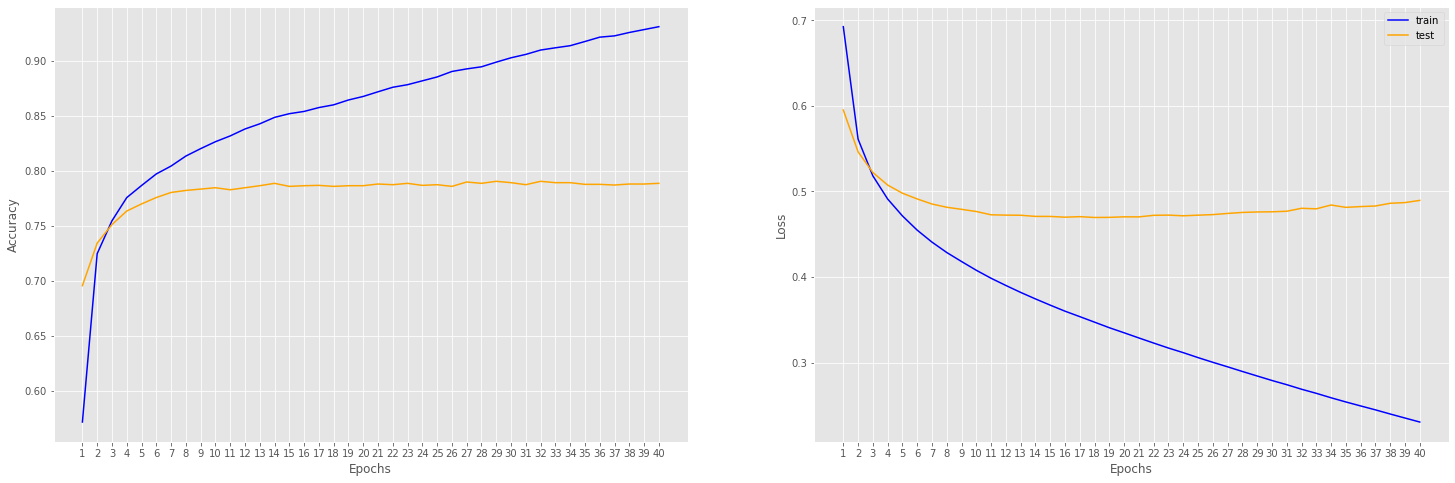

In [36]:
epochs = range(1, EPOCHS+1)
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

axs[0].plot(epochs, history.history['acc'], color='blue', label='train')
axs[0].plot(epochs, history.history['val_acc'], color='orange', label='test')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(epochs, history.history['loss'], color='blue', label='train')
axs[1].plot(epochs, history.history['val_loss'], color='orange', label='test')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
plt.legend()

* The best score reaches 0.79 of accuracy

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19a4c9de9d0>)

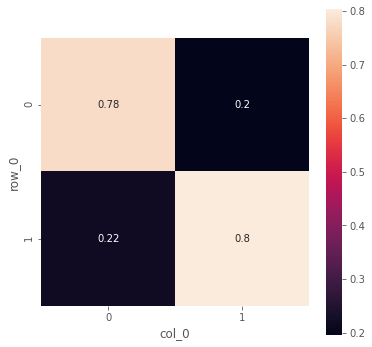

In [37]:
y_pred = model.predict(X_test).reshape(1, -1)[0]
y_pred = np.around(y_pred).astype(int)

plot_confusion_matrix(y_test, y_pred)

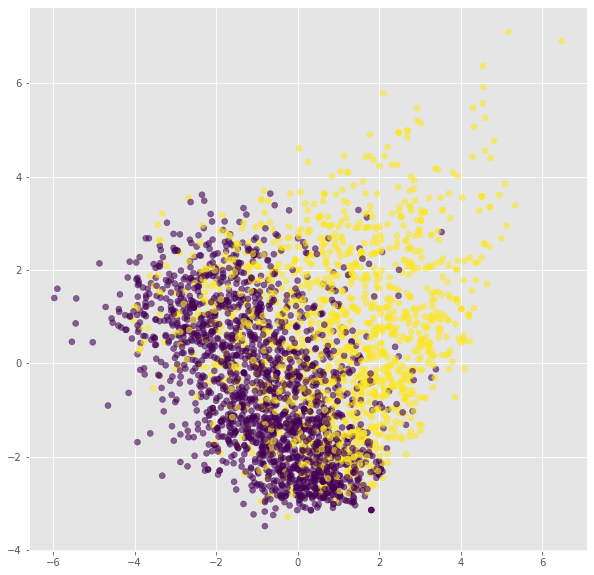

In [41]:
from sklearn.decomposition import PCA

embed = lambda x: c(b(a(x)))
embedded_text = embed(X_test)

twodim = PCA(2).fit_transform(embedded_text)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(twodim[:,0], twodim[:,1], c=y_test, alpha=.6)

* The model managed to approximatively separate tweets

In [10]:
df_test['pred'] = y_pred
model_errors = df_test[df_test['pred'] != df_test['target']]
model_errors

,id,keyword,text,target,source,clean_text,pred
6861,70,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,0,test,burning man ablaze by turban diva via,1
6867,90,ablaze,'Burning Rahm': Let's hope City Hall builds a ...,0,test,burning rahm let is hope city hall builds a g...,1
6872,106,accident,#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Came...,0,test,car recorder zeroedge dual lens car camera ve...,1
6885,148,aftershock,@bxckylynch foi no ROH Aftershock: Las Vegas p...,0,test,foi no roh aftershock las vegas procura no pi...,1
6901,202,airplane%20accident,@rewind_music found out about you guys today(r...,1,test,found out about you guys today regarding the ...,0
...,...,...,...,...,...,...,...
10084,10797,wrecked,@Nathan26_RFC thought you said Saturday night ...,0,test,thought you said saturday night there and nea...,1
10086,10804,wrecked,@yakubOObs think he deactivated because his no...,1,test,think he deactivated because his notification...,0
10087,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...,1,test,rt cnbc words from disney ceo bob iger wrecked...,0
10098,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0,test,earthquake safety los angeles safety fasteners...,1


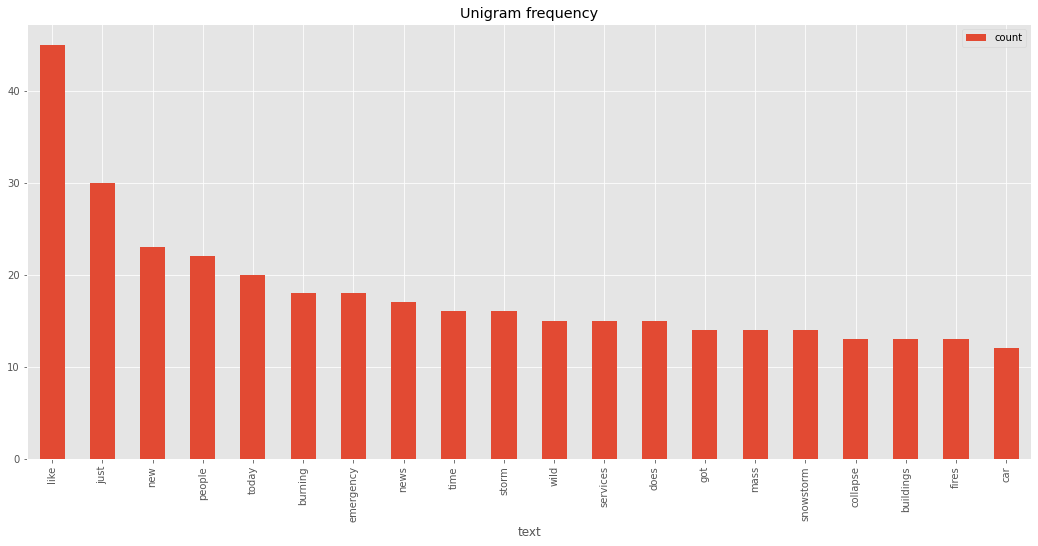

In [38]:
top_unigrams = get_top_grams(model_errors['clean_text'], 20)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_unigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Unigram frequency')

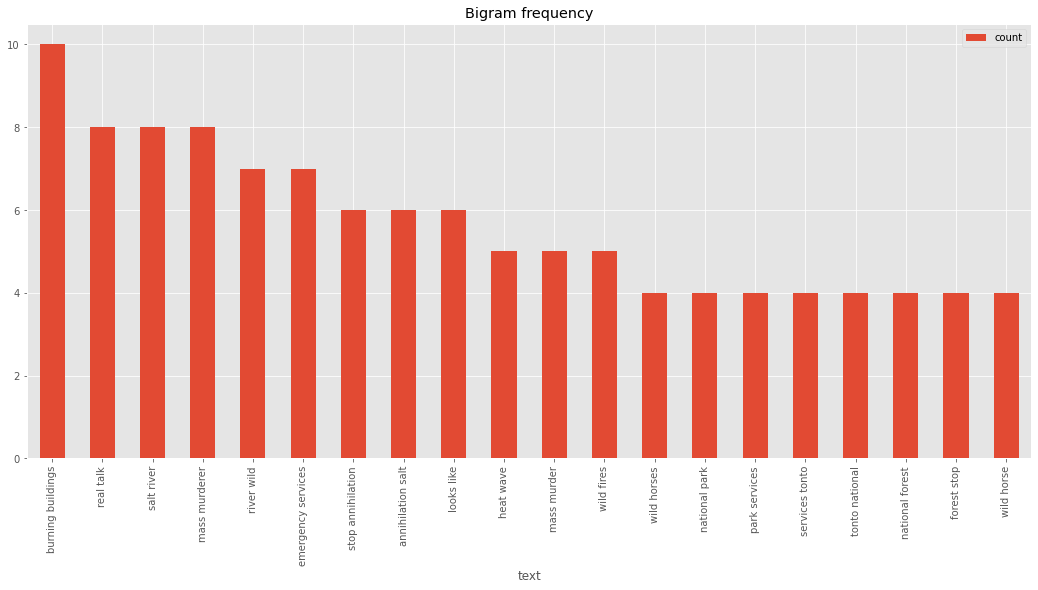

In [39]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=2)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Bigram frequency')

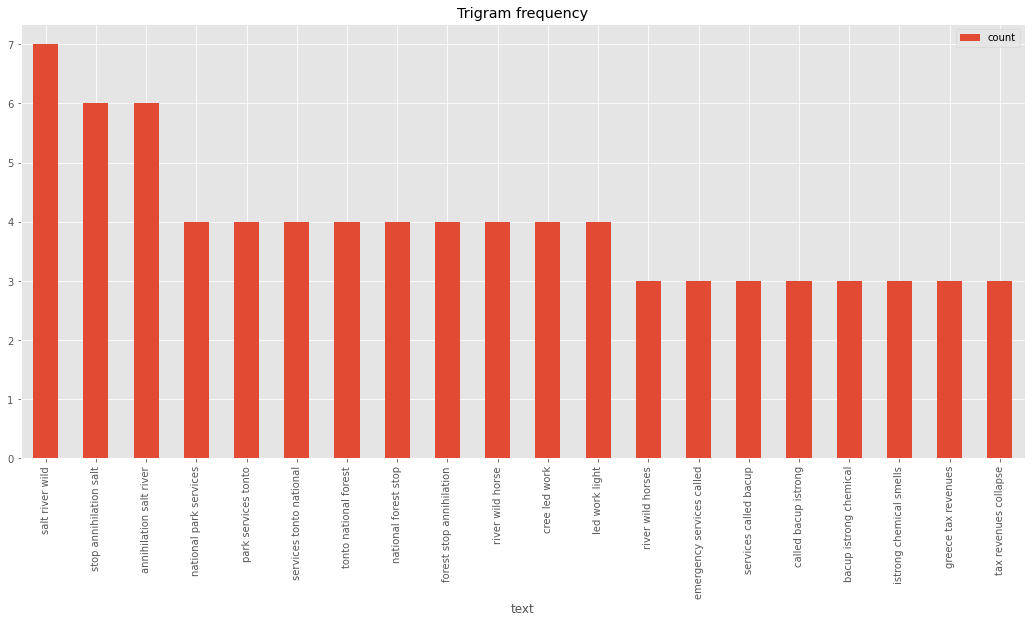

In [40]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=3)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Trigram frequency')